# Set up the class fundementals 

In [1]:
# import os, sys
# import collections
import numpy as np
# import matplotlib.markers as markers
# import matplotlib.pyplot as plt
# import timeit
# import collections
# from scipy.stats import median_abs_deviation as mad
# import multiprocessing
# import cProfile
# import itertools
from numba import jit, njit
from bed_reader import open_bed
# import warnings
# warnings.filterwarnings('ignore') # this is just to hide all the warnings
# import rpy2.robjects as robjects
# import matplotlib.pyplot as plt # change font globally to Times 
# plt.style.use('ggplot')
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Times New Roman",
#     "font.sans-serif": ["Times New Roman"],
#     "font.size": 12})

# os.chdir(sys.path[0]) # ensure working direcotry is set same as the file

ModuleNotFoundError: No module named 'bed_reader'

In [2]:
opy1######################################  some SCAD and MCP things  #######################################
@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def soft_thresholding(x, lambda_):
    '''
    To calculate soft-thresholding mapping of a given ONE-DIMENSIONAL tensor, BESIDES THE FIRST TERM (so beta_0 will not be penalized). 
    This function is to be used for calculation involving L1 penalty term later. 
    '''
    return np.hstack((np.array([x[0]]), np.where(np.abs(x[1:])>lambda_, x[1:] - np.sign(x[1:])*lambda_, 0)))

soft_thresholding(np.random.rand(20),3.1)

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def SCAD(x, lambda_, a=3.7):
    '''
    To calculate SCAD penalty value;
    #x can be a multi-dimensional tensor;
    lambda_, a are scalars;
    Fan and Li suggests to take a as 3.7 
    '''
    # here I notice the function is de facto a function of absolute value of x, therefore take absolute value first to simplify calculation 
    x = np.abs(x)
    temp = np.where(x<=lambda_, lambda_*x, np.where(x<a*lambda_, (2*a*lambda_*x - x**2 - lambda_**2)/(2*(a - 1)), lambda_**2 * (a+1)/2))
    temp[0] = 0. # this is to NOT penalize intercept beta later 
    return temp 

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def SCAD_grad(x, lambda_, a=3.7):
    '''
    To calculate the gradient of SCAD wrt. input x; 
    #x can be a multi-dimensional tensor. 
    '''
    # here decompose x to sign and its absolute value for easier calculation
    sgn = np.sign(x)
    x = np.abs(x)
    temp = np.where(x<=lambda_, lambda_*sgn, np.where(x<a*lambda_, (a*lambda_*sgn-sgn*x)/(a-1), 0))
    temp[0] = 0. # this is to NOT penalize intercept beta later 
    return temp 

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def MCP(x, lambda_, gamma):
    '''
    To calculate MCP penalty value; 
    #x can be a multi-dimensional tensor. 
    '''
    # the function is a function of absolute value of x 
    x = np.abs(x)
    temp = np.where(x<=gamma*lambda_, lambda_*x - x**2/(2*gamma), .5*gamma*lambda_**2)
    temp[0] = 0. # this is to NOT penalize intercept beta later 
    return temp 

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def MCP_grad(x, lambda_, gamma):
    '''
    To calculate MCP gradient wrt. input x; 
    #x can be a multi-dimensional tensor. 
    '''
    temp = np.where(np.abs(x)<gamma*lambda_, lambda_*np.sign(x)-x/gamma, np.zeros_like(x))
    temp[0] = 0. # this is to NOT penalize intercept beta later 
    return temp 

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def SCAD_concave(x, lambda_, a=3.7):
    '''
    The value of concave part of SCAD penalty; 
    #x can be a multi-dimensional tensor. 
    '''
    x = np.abs(x)
    temp = np.where(x<=lambda_, 0., np.where(x<a*lambda_, (lambda_*x - (x**2 + lambda_**2)/2)/(a-1), (a+1)/2*lambda_**2 - lambda_*x))
    temp[0] = 0. # this is to NOT penalize intercept beta later 
    return temp 

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def SCAD_concave_grad(x, lambda_, a=3.7):
    '''
    The gradient of concave part of SCAD penalty wrt. input x; 
    #x can be a multi-dimensional tensor. 
    '''
    sgn = np.sign(x)
    x = np.abs(x)
    temp = np.where(x<=lambda_, 0., np.where(x<a*lambda_, (lambda_*sgn-sgn*x)/(a-1), -lambda_*sgn))
    temp[0] = 0. # this is to NOT penalize intercept beta later 
    return temp 

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def MCP_concave(x, lambda_, gamma):
    '''
    The value of concave part of MCP penalty; 
    #x can be a multi-dimensional tensor. 
    '''
    # similiar as in MCP
    x = np.abs(x)
    temp = np.where(x<=gamma*lambda_, -(x**2)/(2*gamma), (gamma*lambda_**2)/2 - lambda_*x)
    temp[0] = 0. # this is to NOT penalize intercept beta later 
    return temp 

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def MCP_concave_grad(x, lambda_, gamma):
    '''
    The gradient of concave part of MCP penalty wrt. input x; 
    #x can be a multi-dimensional tensor. 
    '''
    temp = np.where(np.abs(x) < gamma*lambda_, -x/gamma, -lambda_*np.sign(x))
    temp[0] = 0. # this is to NOT penalize intercept beta later 
    return temp 


# Implementation

In [3]:
# @jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def _SNP_update_smooth_grad_convex_LM(N, p, bed, beta_md, y, _dtype, _order):
    '''
    Update the gradient of the smooth convex objective component.
    '''
    _itemsize = np.dtype(_dtype).itemsize
    # first calcualte _=X@beta_md-y
    _ = np.zeros(N)
    if _order == "F":
        for j in np.arange(p):
            _X = np.memmap(bed, dtype=_dtype, mode='r', offset=j*_itemsize*N, shape = (N,))
            _ += _X*beta_md[j]
    elif _order == "C":
        for j in np.arange(N):
            _X = np.memmap(bed, dtype=_dtype, mode='r', offset=j*_itemsize*p, shape = (p,))
            _[j] = _X@beta_md
    _ -= y
    # then calculate _XTXbeta = X.T@X@beta_md = X.T@_
    _XTXbeta = np.zeros(p)
    if _order == "F":
        for j in np.arange(p):
            _X = np.memmap(bed, dtype=_dtype, mode='r', offset=j*_itemsize*N, shape = (N,))
            _XTXbeta[j] = _X@_
    elif _order == "C":
        for j in np.arange(N):
            _X = np.memmap(bed, dtype=_dtype, mode='r', offset=j*_itemsize*p, shape = (p,))
            _XTXbeta += _X*_[j]
    del _
    return 1/N*_XTXbeta

# @jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def _SNP_update_smooth_grad_SCAD_LM(N, p, bed, beta_md, y, _lambda, a, _dtype, _order):
    '''
    Update the gradient of the smooth objective component for SCAD penalty.
    '''
    return _SNP_update_smooth_grad_convex_LM(N=N, p=p, X=bed, beta_md=beta_md, y=y, _dtype=_dtype, _order=_order) + SCAD_concave_grad(x=beta_md, lambda_=_lambda, a=a)

# @jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def _SNP_update_smooth_grad_MCP_LM(N, p, bed, beta_md, y, _lambda, gamma, _dtype, _order):
    '''
    Update the gradient of the smooth objective component for MCP penalty.
    '''
    return _SNP_update_smooth_grad_convex_LM(N=N, p=p, X=bed, beta_md=beta_md, y=y, _dtype=_dtype, _order=_order) + MCP_concave_grad(x=beta_md, lambda_=_lambda, gamma=gamma)


# @jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def _SNP_lambda_max_LM(bed, y, N, p, _dtype, _order):
    """
    Calculate the lambda_mabed, i.e., the minimum lambda to nullify all penalized betas.
    """
#     X_temp = X.copy()
#     X_temp = X_temp[:,1:]
#     X_temp -= np.mean(X_temp,0).reshape(1,-1)
#     X_temp /= np.std(X_temp,0)
#     y_temp = y.copy()
#     y_temp -= np.mean(y)
#     y_temp /= np.std(y)
    _itemsize = np.dtype(_dtype).itemsize
    _ = np.zeros(p)
    if _order == "F":
        for j in np.arange(p):
            _X = np.memmap(bed, dtype=_dtype, mode='r', offset=j*_itemsize*N, shape = (N,))
            _[j] = _X@y
    elif _order == "C":
        for j in np.arange(N):
            _X = np.memmap(bed, dtype=_dtype, mode='r', offset=j*_itemsize*p, shape = (p,))
            _ += _X*y[j]

    grad_at_0 = _[1:]/N
    lambda_max = np.linalg.norm(grad_at_0, ord=np.infty)
    return lambda_max



# @jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def SNP_UAG_LM_SCAD_MCP(design_matribed, outcome, N, p, L_convebed, _dtype, _order, beta_0 = np.ones(1), tol=1e-2, maxit=500, _lambda=.5, penalty="SCAD", a=3.7, gamma=2.):
    '''
    Carry out the optimization for penalized LM for a fixed lambda.
    '''
    X = design_matrix
    y = outcome
    _itemsize = np.dtype(_dtype).itemsize
    if np.all(beta_0==np.ones(1)):
        _ = np.zeros(p)
        if _order == "F":
            for j in np.arange(p):
                _X = np.memmap(bed, dtype=_dtype, mode='r', offset=j*_itemsize*N, shape = (N,))
                _[j] = _X@y
        elif _order == "C":
            for j in np.arange(N):
                _X = np.memmap(bed, dtype=_dtype, mode='r', offset=j*_itemsize*p, shape = (p,))
                _ += _X*y[j]
        beta = np.sign(_)
    else:
        beta = beta_0
    # passing other parameters
    smooth_grad = np.ones(p)
    beta_ag = beta.copy()
    beta_md = beta.copy()
    k = 0
    converged = False
    opt_alpha = 1.
    old_speed_norm = 1.
    speed_norm = 1.
    restart_k = 0
    
    if penalty == "SCAD":
#         L = np.max(np.array([L_convebed, 1./(a-1)]))
        L = np.linalg.norm(np.array([L_convebed, 1./(a-1)]), ord=np.infty)
        opt_beta = .99/L
        while ((not converged) or (k<3)) and k <= maxit:
            k += 1
            if old_speed_norm > speed_norm and k - restart_k>=3: # in this case, restart
                opt_alpha = 1. # restarting
                restart_k = k # restarting
            else: # restarting
                opt_alpha = 2/(1+(1+4./opt_alpha**2)**.5) #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound 
            opt_lambda = opt_beta/opt_alpha #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
            beta_md_old = beta_md.copy() # restarting
            beta_md = (1-opt_alpha)*beta_ag + opt_alpha*beta
            old_speed_norm = speed_norm # restarting
            speed_norm = np.linalg.norm(beta_md - beta_md_old, ord=2) # restarting
            converged = (np.linalg.norm(beta_md - beta_md_old, ord=np.infty) < tol)
            smooth_grad = _SNP_update_smooth_grad_SCAD_LM(N=N, p=p, X=bed, beta_md=beta_md, y=y, _lambda=_lambda, a=a, _dtype=_dtype, _order=_order)
            beta = soft_thresholding(x=beta - opt_lambda*smooth_grad, lambda_=opt_lambda*_lambda)
            beta_ag = soft_thresholding(x=beta_md - opt_beta*smooth_grad, lambda_=opt_beta*_lambda)
#             converged = np.all(np.max(np.abs(beta_md - beta_ag)/opt_beta) < tol).item()
#             converged = (np.linalg.norm(beta_md - beta_ag, ord=np.infty) < (tol*opt_beta))
    else:
#         L = np.max(np.array([L_convebed, 1./(gamma)]))
        L = np.linalg.norm(np.array([L_convebed, 1./(gamma)]), ord=np.infty)
        opt_beta = .99/L
        while ((not converged) or (k<3)) and k <= maxit:
            k += 1
            if old_speed_norm > speed_norm and k - restart_k>=3: # in this case, restart
                opt_alpha = 1. # restarting
                restart_k = k # restarting
            else: # restarting
                opt_alpha = 2/(1+(1+4./opt_alpha**2)**.5) #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound 
            opt_lambda = opt_beta/opt_alpha #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
            beta_md_old = beta_md.copy() # restarting
            beta_md = (1-opt_alpha)*beta_ag + opt_alpha*beta
            old_speed_norm = speed_norm # restarting
            speed_norm = np.linalg.norm(beta_md - beta_md_old, ord=2) # restarting
            converged = (np.linalg.norm(beta_md - beta_md_old, ord=np.infty) < tol)
            smooth_grad = _SNP_update_smooth_grad_MCP_LM(N=N, p=p, X=bed, beta_md=beta_md, y=y, _lambda=_lambda, gamma=gamma, _dtype=_dtype, _order=_order)
            beta = soft_thresholding(x=beta - opt_lambda*smooth_grad, lambda_=opt_lambda*_lambda)
            beta_ag = soft_thresholding(x=beta_md - opt_beta*smooth_grad, lambda_=opt_beta*_lambda)
#             converged = np.all(np.max(np.abs(beta_md - beta_ag)/opt_beta) < tol).item()
#             converged = (np.linalg.norm(beta_md - beta_ag, ord=np.infty) < (tol*opt_beta))
    return k, beta_md


# @jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def SNP_solution_path_LM(design_matribed, outcome, lambda_, L_convebed, N, p, beta_0 = np.ones(1), tol=1e-2, maxit=500, penalty="SCAD", a=3.7, gamma=2., _dtype='float32', _order="F"):
    '''
    Carry out the optimization for the solution path without the strong rule.
    '''
    beta_mat = np.zeros((len(lambda_)+1, p))
    for j in range(len(lambda_)): 
        beta_mat[j+1,:] = SNP_UAG_LM_SCAD_MCP(design_matrix=design_matribed, outcome=outcome, N=N, p=p, L_convex=L_convebed, beta_0 = beta_mat[j,:], tol=tol, maxit=maxit, _lambda=lambda_[j], penalty=penalty, a=a, gamma=gamma, _dtype=_dtype, _order=_order,)[1]
    return beta_mat[1:,:]



# Testing

In [4]:
import matplotlib.markers as markers
import matplotlib.pyplot as plt
import timeit
from scipy.linalg import toeplitz, block_diag


np.random.seed(1)
N = 1000
SNR = 5.
true_beta = np.array([2,-2,8,-8]+[0]*1000)
X_cov = toeplitz(.6**np.arange(true_beta.shape[0]))
mean = np.zeros(true_beta.shape[0])
X = np.random.multivariate_normal(mean, X_cov, N)
X -= np.mean(X,0).reshape(1,-1)
X /= np.std(X,0)
intercept_design_column = np.ones(N).reshape(N, 1)
X_sim = np.concatenate((intercept_design_column, X), 1)
true_sigma_sim = np.sqrt(true_beta.T@X_cov@true_beta/SNR)
true_beta_intercept = np.concatenate((np.array([1.23]), true_beta)) # here just define the intercept to be 1.23 for simulated data 
epsilon = np.random.normal(0, true_sigma_sim, N)
y_sim = X_sim@true_beta_intercept + epsilon



lambda_seq = np.arange(40)/400
lambda_seq = lambda_seq[1:]
lambda_seq = lambda_seq[::-1]

# do NOT include the design matrix intercept column 
LM_beta = solution_path_LM_strongrule(design_matrix=X_sim, outcome=y_sim, lambda_=lambda_seq, beta_0 = np.ones(1), tol=1e-2, maxit=500, penalty="SCAD", a=3.7, gamma=2., add_intercept_column=True)

print(LM_beta) # to make sure strong rule runs correctly 

%timeit solution_path_LM_strongrule(design_matrix=X_sim, outcome=y_sim, lambda_=lambda_seq, beta_0 = np.ones(1), tol=1e-2, maxit=500, penalty="SCAD", a=3.7, gamma=2., add_intercept_column=True)

C:\Users\alphaIto\AppData\Local\Temp\ipykernel_16288\932946465.py:345: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 2d, A))
  _lambda_max = lambda_max_LM(_design_matrix, outcome)
C:\Users\alphaIto\AppData\Local\Temp\ipykernel_16288\932946465.py:345: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 2d, A))
  _lambda_max = lambda_max_LM(_design_matrix, outcome)
C:\Users\alphaIto\AppData\Local\Temp\ipykernel_16288\932946465.py:349: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 2d, A))
  _elim = strong_rule_seq_LM(X=_design_matrix, y=outcome, beta_old=beta_mat[j,:], lambda_new=lambda_[j+1], lambda_old=lambda_[j])
C:\Users\alphaIto\AppData\Local\Temp\ipykernel_16288\932946465.py:349: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  _e

[[ 1.25145030e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.25529911e+00  1.93834934e+00 -1.87491707e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.25529773e+00  1.94263335e+00 -1.88578904e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 1.25529526e+00  1.87673754e+00 -1.91218195e+00 ...  7.69226132e-02
  -8.24977017e-02  0.00000000e+00]
 [ 1.25529526e+00  1.87214777e+00 -1.90930101e+00 ...  8.90060269e-02
  -8.95442224e-02  0.00000000e+00]
 [ 1.25529526e+00  1.86767007e+00 -1.90691276e+00 ...  1.00662533e-01
  -9.61300285e-02  1.36140337e-04]]
4.15 s ± 97.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
# this cell is for profiling the function 
np.random.seed(0)
N = 1000
p_zeros = 2000
SNR = 5.
true_beta = np.array([2,-2,8,-8]+[0]*p_zeros)
X_cov = toeplitz(0.6**np.arange(len(true_beta)))
mean = np.zeros(len(true_beta))
X = np.random.multivariate_normal(mean, X_cov, N)
X -= np.mean(X,0).reshape(1,-1)
X /= np.std(X,0)
intercept_design_column = np.ones(N).reshape(N, 1)
X_sim = np.concatenate((intercept_design_column, X), 1)
true_sigma_sim = np.sqrt(true_beta.T@X_cov@true_beta/SNR)
true_beta_intercept = np.concatenate((np.array([1.23]), true_beta)) # here just define the intercept to be 1.23 for simulated data 
epsilon = np.random.normal(0, true_sigma_sim, N)
y_sim = X_sim@true_beta_intercept + epsilon

fit1 = UAG_LM_SCAD_MCP_strongrule(design_matrix=X_sim, outcome=y_sim, tol=1e-2, maxit=500, _lambda=.2, penalty="SCAD", a=3.7, gamma=2.)

fit2 = solution_path_LM(design_matrix=X_sim, outcome=y_sim, tol=1e-2, maxit=500, lambda_=np.linspace(.1,1,100), penalty="SCAD", a=3.7, gamma=2.)

C:\Users\alphaIto\AppData\Local\Temp\ipykernel_16288\932946465.py:198: NumbaWarning: Cannot cache compiled function "solution_path_LM" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)


In [6]:
%timeit UAG_LM_SCAD_MCP_strongrule(design_matrix=X_sim, outcome=y_sim, tol=1e-2, maxit=500, _lambda=.5, penalty="MCP", a=3.7, gamma=2.)


1.16 s ± 34.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
fit1

(66,
 array([ 1.28598359,  2.15247208, -1.92370802, ...,  0.        ,
         0.16219557,  0.        ]))

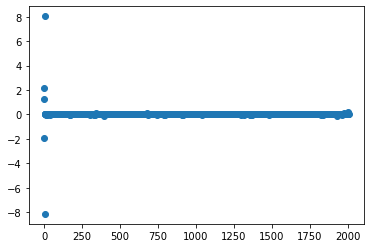

In [8]:
plt.plot(np.arange(len(fit1[1])), fit1[1], 'o')
plt.show()
